In [2]:
import os 
import pandas as pd
    
import json
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import glob
import allel
import itertools
from matplotlib import gridspec
import matplotlib.pyplot as plt
import pickle
from statannot import add_stat_annotation
from scipy import stats
import matplotlib.cm as cm
import matplotlib

from math import pi
import scipy
import scipy.stats as st

pd.options.display.max_columns=200
pd.options.display.max_rows=100
from pandas.core.common import SettingWithCopyWarning
import warnings
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

# Important: 

The code to parse the raw somatic files across all PCAWG samples has been placed in the ../0_process_data/GIE_events/ folder. 

-- GIE events across PCAWG samples -> generated by the concat_reports_pcawg.py script and copied into ../results/data/raw_data_gie_pcawg.tsv

-- Immune infiltration across PCAWG samples -> generated by the pipeline_infiltration_PCAWG.py and copied into ../results/data/raw_data_immune_pcawg.tsv

In [3]:
path_escape="../results/data/raw_data_gie_pcawg.tsv" # change this with your path
path_rna="../results/data/raw_data_immune_pcawg.tsv" # change this with your path

In [4]:
def prepare_metadata():
    df_meta = pd.read_csv("../metadata/dataset_metadata_supp_table3.tsv",sep="\t")
    df_meta=df_meta[(df_meta["is_selected"]==True)]
    return df_meta[df_meta["cohort"]=="PCAWG"]
df = pd.read_csv(f"{path_escape}",sep="\t").rename(columns={"sample":"sample_id"})
df_metadata = prepare_metadata()
df=df.merge(df_metadata)
df_rna = pd.read_csv(f"{path_rna}",sep="\t")
df = df.merge(df_rna,how="left")
summary_cohort = pd.read_csv("../metadata/table_cancer_types_info.tsv",sep="\t")

In [5]:
df.shape

(1880, 134)

### Define alterations to be considered

In [6]:
allowed_csq = set(["frameshift_variant","stop_gained","stop_lost","splice_acceptor_variant","splice_donor_variant","stop_gained","splice_region_variant","start_lost"]) # monoallelic
allowed_csq_biallelic = set(["missense_variant","structural_interaction_variant","conservative_inframe_deletion","conservative_inframe_insertion","disruptive_inframe_deletion","disruptive_inframe_insertion"]) # only biallelic 
alterations = pd.read_csv("../metadata/immune_selected_genes.tsv",sep="\t") # Supp. Table 1
alterations=alterations[alterations["Selected"]]

def app_pathway(row):
    selected_genes = alterations[alterations["Pathway_general"]=="Antigen Presentation Pathway"]["Gene"].values
    for gene in selected_genes:
        if (gene in str(row["del_scaffold_mhc"])) or (gene in str(row["del_tfs"])) or (gene in str(row["del_transport_mhc"])): 
            return pd.Series([True, f"del {gene}"])
        elif (is_clonally_mutated(gene,row["mut_scaffold_mhc"]) or (is_clonally_mutated(gene, row["mut_tfs"])) or (is_clonally_mutated(gene, row["mut_transport_mhc"]))):
            return pd.Series([True, f"mut {gene}"])
    return pd.Series([False,""])
            
def ifn_gamma_pathway(row):
    selected_genes=alterations[alterations["Pathway_general"]=="IFN-gamma pathway"]["Gene"].values
    for gene in selected_genes:
        if (gene in str(row["del_interferon"])): 
            return pd.Series([True, f"del {gene}"])
        elif (is_clonally_mutated(gene,row["mut_interferon"])):
            return pd.Series([True, f"mut {gene}"])
    return pd.Series([False,""])

def cd58_pathway(row):
    selected_genes=["CD58"]
    for gene in selected_genes:
        if (gene in str(row["del_cd58"])): 
            return pd.Series([True, f"del {gene}"])
        elif (is_clonally_mutated(gene,row["mut_cd58"])):
            return pd.Series([True, f"mut {gene}"])
    return pd.Series([False,""])

def checkpoint_pathway(row):
    genes = ["CD274"]
    for gene in genes:
        if gene in str(row["amps_inhibitors"]):
            return pd.Series([True,f"amp {gene}"])
    return pd.Series([False,""])

def epigenetic_regulators_pathway(row):
    genes = ["SETDB1"]
    for gene in genes:
        if gene in str(row["epigenetic_regulators"]):
            return pd.Series([True,f"amp {gene}"])
    return pd.Series([False,""])

def is_clonally_mutated(gene,muts):
    if not(";") in str(muts):
        return False
    muts_gene=0
    for mut in muts.split("___"):
       
        gene_mut,csq,allelic_status,germline_status,clonality_purple,clonality_timing,af,cn,macn=mut.split(";")
         
        if gene == gene_mut and (clonality_purple.startswith("clonal"))  and (len(set(csq.split("&")).intersection(allowed_csq))) >0: 
            return True # At least one clonal deleterios mutations
        if gene == gene_mut and (clonality_purple.startswith("clonal")) and allelic_status == "biallelic" and (len(set(csq.split("&")).intersection(allowed_csq_biallelic))) >0 :
            return True # At least one biallelic deleterios or non-synonymous likely impactful mutation (missense)
        if gene == gene_mut and (clonality_purple.startswith("clonal")) and allelic_status == "monoallelic" and (len(set(csq.split("&")).intersection(allowed_csq_biallelic))) >0:
            muts_gene+=1 # multiple non-synonymous monoallelic mutations
    return muts_gene>1 # multipl, at least two, non-synonymous monoallelic mutations

### Define type of alterations

In [7]:
df[["systemic_app_pathway","systemic_app_pathway_detail"]]  = df.apply(lambda row: app_pathway(row),axis=1)          
df[["cd58_pathway","cd58_pathway_detail"]]  = df.apply(lambda row: cd58_pathway(row),axis=1)          
df[["ifn_gamma_pathway","ifn_gamma_pathway_detail"]]  = df.apply(lambda row: ifn_gamma_pathway(row),axis=1)          
df[["checkpoint_pathway","checkpoint_pathway_detail"]]  = df.apply(lambda row: checkpoint_pathway(row),axis=1)
df[["epigenetic_regulators_pathway","epigenetic_regulators_pathway_detail"]]  = df.apply(lambda row: epigenetic_regulators_pathway(row),axis=1)
df["targeted_app_pathway_mut_HLA"] = df.apply(lambda row: row["mut_hla_lilac"],axis=1)
df["targeted_app_pathway_loh_HLA"] = df.apply(lambda row: row["loh_lilac"] ,axis=1)
df["targeted_app_pathway_del_HLA"] = df.apply(lambda row: (row["del_HLA-A"] == 1.) | (row["del_HLA-B"] == 1.) | (row["del_HLA-C"] == 1.) ,axis=1)
df["targeted_app_pathway_partdel_HLA"] = df.apply(lambda row: row["targeted_app_pathway_loh_HLA"] | row["targeted_app_pathway_del_HLA"] ,axis=1)
df["targeted_escape"] = df["targeted_app_pathway_mut_HLA"] | df["targeted_app_pathway_loh_HLA"] | df["targeted_app_pathway_del_HLA"]
df["non_targeted_escape"] = df["systemic_app_pathway"] | df["ifn_gamma_pathway"] | df["checkpoint_pathway"] | df["cd58_pathway"] | df["epigenetic_regulators_pathway"]
df["genetic_immune_escape"] = df["targeted_escape"] | df["non_targeted_escape"]

### Annotate type of LOH HLA (copy number neutral or dosage imbalance)

In [8]:
def get_copy_number_neutral_loh(row):
    if not(row["loh_lilac"]):
        return ""
    if "HLA" in str(row["loh_nonfocal"]):
        hlas= row["loh_nonfocal"].split(",")
    elif "HLA" in str(row["loh_focal"]):
        hlas= row["loh_focal"].split(",")
    else:
        hlas= row["loh_hfocal"].split(",")
    l=[]
    for hla in hlas:
        if row["ploidy_major_"+hla] >1:
            l.append(hla)
    return ",".join(l)
    


df["copy_number_neutral_loh_hla"] = df.apply(lambda row: get_copy_number_neutral_loh(row),axis=1)

In [9]:
df[df["loh_lilac"]==True]["copy_number_neutral_loh_hla"].value_counts()

HLA-A,HLA-C,HLA-B    169
                     143
HLA-A                  3
HLA-C,HLA-B            2
HLA-A,HLA-B            1
Name: copy_number_neutral_loh_hla, dtype: int64

In [10]:
df[(df["loh_lilac"]==True)&(df["loh_nonfocal"].str.contains("HLA",na=False))]["copy_number_neutral_loh_hla"].value_counts()

                     87
HLA-A,HLA-C,HLA-B    46
Name: copy_number_neutral_loh_hla, dtype: int64

In [11]:
46 / (46+87 )

0.3458646616541353

In [12]:
df[(df["loh_lilac"]==True)&(df["loh_focal"].str.contains("HLA",na=False))]["copy_number_neutral_loh_hla"].value_counts()

HLA-A,HLA-C,HLA-B    123
                      56
HLA-A                  3
HLA-C,HLA-B            2
HLA-A,HLA-B            1
Name: copy_number_neutral_loh_hla, dtype: int64

In [13]:
(123+3+2+1) / (123+3+2+1+56)

0.6972972972972973

In [14]:
df[(df["loh_lilac"]==True)&(df["loh_hfocal"].str.contains("HLA",na=False))]["copy_number_neutral_loh_hla"].value_counts()

HLA-A,HLA-C,HLA-B    24
                     11
HLA-A                 3
HLA-C,HLA-B           2
HLA-A,HLA-B           1
Name: copy_number_neutral_loh_hla, dtype: int64

In [15]:
(24+3+2+1) / (24+3+2+1+11)

0.7317073170731707

### Store the table with GIE events per PCAWG sample, this will be key part of Supp. Table 4

In [18]:
df.to_csv("../results/data/processed_pcawg_escape_info.tsv.gz",sep="\t",compression="gzip",index=False)

In [16]:
df.shape

(1880, 152)

# Define global GIE prevalence primary


In [5]:
df = pd.read_csv("../results/data/processed_pcawg_escape_info.tsv.gz",sep="\t")

### Load ttypes selected

In [17]:
ttypes_selected=summary_cohort[summary_cohort["group_PCAWG"]]["cancer_type"].values

### Define pathways

In [18]:
features = ["targeted_app_pathway_mut_HLA","targeted_app_pathway_partdel_HLA","systemic_app_pathway","ifn_gamma_pathway","checkpoint_pathway","cd58_pathway","epigenetic_regulators_pathway","genetic_immune_escape"]
names = ["Somatic mutation HLA","LOH/partial del. HLA","Antigen presentation pathway","IFN-gamma pathway", "PD-L1 amplification","CD58 alteration","Epigenetic regulation by SETDB1","Genetic immune escape \n (GIE)"]

### Show variation across tumor types, only tumor types with sufficient representation

In [19]:
tmp=df[["targeted_app_pathway_mut_HLA","targeted_app_pathway_partdel_HLA"]].sum(axis=0)
tmp_norm = (tmp / df.shape[0])
tmp_norm

targeted_app_pathway_mut_HLA        0.019681
targeted_app_pathway_partdel_HLA    0.169681
dtype: float64

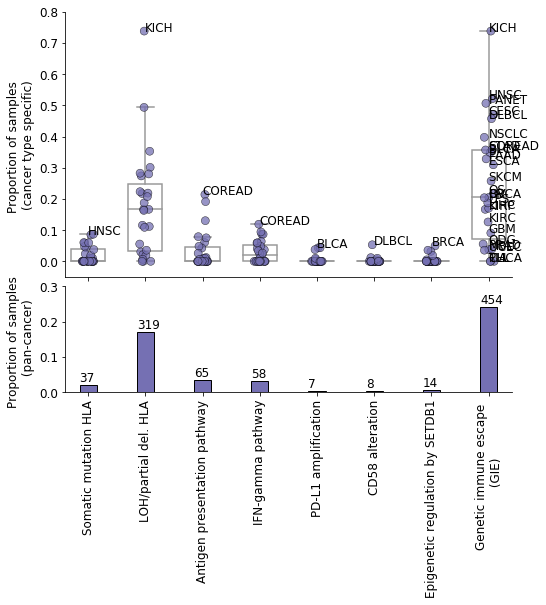

In [20]:
fig,ax=plt.subplots(figsize=(8,7))
gs = gridspec.GridSpec(figure=fig, ncols=1, nrows=2, height_ratios=[5,2])
gs.update(hspace=0.05, wspace=0.0)
# distplot
ax0 = plt.subplot(gs[0])
ax1 = plt.subplot(gs[1],sharex=ax0)
pallete = {"wt":"#ef8a62","alteration":"#67a9cf","alteration_primary":"#7570b3"}
'''
boxplot
'''
a=df[df["cancer_type"].isin(ttypes_selected)].groupby(["cancer_type_code"]).agg(dict([(feature,np.nanmean) for feature in features]+[("sample_id","count")])).reset_index()
a=a[a["sample_id"]>=15]
b=a[features+["cancer_type_code"]].melt(id_vars=["cancer_type_code"])
b=b.merge(a[["cancer_type_code","sample_id"]])
b["size"] = np.log2(b["sample_id"]+1)

g=sns.boxplot(data=b,x="variable",y="value",showfliers=False,color="white",linewidth=1.5,ax=ax0,width=0.6)

sns.stripplot(data=b,x="variable",y="value",alpha=0.75,color=pallete["alteration_primary"],ax=ax0,linewidth=0.5,edgecolor="black",s=8)
ax0.set_ylabel("Proportion of samples \n(cancer type specific)",fontsize=12)
ax0.set_xlabel("")
ax0.spines['top'].set_visible(False)
ax0.spines['right'].set_visible(False)
ax0.set_xticks(range(0,len(features)))
# plot several examples
i=0
for k,v in dict(a[a["sample_id"]>=15].set_index("cancer_type_code").idxmax()).items():
    if k in features and k !="genetic_immune_escape":
        ax0.annotate(xy=(i,a[a["cancer_type_code"]==v][k]),s=v,fontsize=12)
        i+=1
for scode in a["cancer_type_code"].values:
    ax0.annotate(xy=(i,a[a["cancer_type_code"]==scode]["genetic_immune_escape"]),s=scode,fontsize=12)
ax0.set_xticklabels([])
ax0.tick_params(axis='both', which='major', labelsize=12)
ax0.set_ylim(-0.05,0.8)
'''
barplot
'''
tmp = df[features].sum(axis=0)
tmp_norm = (tmp / df.shape[0])
tmp_norm.plot(kind="bar",ylim=(0,0.6),ax=ax1,color=pallete["alteration_primary"],edgecolor="black",width=0.3)
N=df.shape[0]

for i,n in enumerate(tmp_norm.index):
    ax1.annotate(xy=(i-0.15,tmp_norm[i]+0.01),s=int(N*tmp_norm[i]),fontsize=12)
ax1.set_ylabel("Proportion of samples \n (pan-cancer)",fontsize=12)
ax1.set_xticklabels(names,fontsize=12)
ax1.set_ylim(0,0.3)
ax1.tick_params(axis='both', which='major', labelsize=12)


_=ax1.set_xticklabels(names,rotation=90,fontsize=12)

ax1.tick_params(axis='both', which='major', labelsize=12)
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)

plt.savefig(f'../results/figures/figure2/boxplot_ttype_frequency_selected_pcawg.pdf', dpi=800,bbox_inches="tight")

In [12]:
a

,cancer_type_code,targeted_app_pathway_mut_HLA,targeted_app_pathway_partdel_HLA,systemic_app_pathway,ifn_gamma_pathway,checkpoint_pathway,cd58_pathway,epigenetic_regulators_pathway,genetic_immune_escape,sample_id
0,BLCA,0.043478,0.217391,0.000000,0.086957,0.043478,0.000000,0.000000,0.347826,23
1,BRCA,0.000000,0.111801,0.012422,0.037267,0.006211,0.000000,0.049689,0.204969,161
2,CESC,0.058824,0.352941,0.000000,0.058824,0.000000,0.000000,0.000000,0.470588,17
3,CLL,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,60
4,COREAD,0.047619,0.166667,0.214286,0.119048,0.000000,0.000000,0.000000,0.357143,42
5,DLBCL,0.085106,0.223404,0.191489,0.021277,0.000000,0.053191,0.000000,0.457447,94
6,ESCA,0.023810,0.273810,0.000000,0.023810,0.000000,0.000000,0.000000,0.309524,84
7,GBM,0.000000,0.030303,0.060606,0.000000,0.000000,0.000000,0.000000,0.090909,33
8,HNSC,0.086957,0.282609,0.130435,0.086957,0.043478,0.000000,0.000000,0.521739,46
9,KICH,0.000000,0.738095,0.000000,0.000000,0.000000,0.000000,0.000000,0.738095,42


In [21]:
a["genetic_immune_escape"].describe()

count    27.000000
mean      0.244037
std       0.191793
min       0.000000
25%       0.073232
50%       0.204969
75%       0.357817
max       0.738095
Name: genetic_immune_escape, dtype: float64

In [14]:
tmp_norm

targeted_app_pathway_mut_HLA        0.019681
targeted_app_pathway_partdel_HLA    0.169681
systemic_app_pathway                0.034574
ifn_gamma_pathway                   0.031383
checkpoint_pathway                  0.003723
cd58_pathway                        0.004255
epigenetic_regulators_pathway       0.007447
genetic_immune_escape               0.241489
dtype: float64

In [15]:
tmp_norm

targeted_app_pathway_mut_HLA        0.019681
targeted_app_pathway_partdel_HLA    0.169681
systemic_app_pathway                0.034574
ifn_gamma_pathway                   0.031383
checkpoint_pathway                  0.003723
cd58_pathway                        0.004255
epigenetic_regulators_pathway       0.007447
genetic_immune_escape               0.241489
dtype: float64

In [16]:
0.004255*1880

7.9994000000000005

### Save a cancer-type summary of GIE events grouped by pathway per cancer type in PCWAG (Supp. Table 4)

In [22]:
a.sort_values("genetic_immune_escape",ascending=False).rename(columns={"sample_id":"n_samples"}).merge(df[["cancer_type_code","cancer_type"]].drop_duplicates()).to_csv("../results/data/summary_gie_cancer_type_pcawg.tsv",sep="\t",index=False)

### Prepare a table with GIE events per gene, not only grouped by pathway (Supp. Table 4)

In [23]:
def ratio(grp):
    total = len(grp)
    return sum(grp) / total
d_counts_ttype=df.groupby(["cancer_type_code"]).agg({"sample_id":"count"}).to_dict()["sample_id"]

In [24]:
cs=['systemic_app_pathway_detail',        'cd58_pathway_detail',        'ifn_gamma_pathway_detail',       'checkpoint_pathway_detail',        'epigenetic_regulators_pathway_detail',       'targeted_app_pathway_mut_HLA', 'targeted_app_pathway_loh_HLA',       'targeted_app_pathway_del_HLA']
l_rs=[]
for c in cs:
    tmp=df[df[c.replace("_detail","")]==True]

    tmp["value"]=True
    tmp=tmp.pivot_table(index=["sample_id","cancer_type_code"],columns=[c],values=["value"],fill_value=False)
    values=[x[1] for x in tmp.columns.values]
    tmp.columns=values
    tmp=tmp.reset_index().groupby("cancer_type_code").agg(dict([(feature,np.nansum) for feature in values]))
    tmp["total_samples"] = tmp.apply(lambda row: d_counts_ttype[row.name],axis=1)
    if not("detail" in c):
        tmp.rename(columns={True:c},inplace=True)
    tmp = tmp.astype(float)
    if not("detail" in c):
        tmpn=pd.DataFrame((tmp[c].div(tmp["total_samples"],axis=0))*100.0,columns=["_".join(c.split("_")[-2:])])
    else:
        tmpn=(tmp[values].div(tmp["total_samples"],axis=0))*100.0
    l_rs.append(tmpn)

stats_gene=pd.concat(l_rs,axis=1).fillna(0.0).reset_index().rename(columns={"index":"cancer_type_code"}).merge(df[["cancer_type_code","cancer_type"]].drop_duplicates())
stats_gene["total_samples"] = stats_gene.apply(lambda row: d_counts_ttype[row.cancer_type_code],axis=1)
stats_gene.to_csv("../results/data/summary_gie_per_gene_cancer_type_pcawg.tsv",sep="\t",index=False)

In [20]:
stats_gene

,cancer_type_code,del B2M,del CALR,del NLRC5,del TAPBP,mut B2M,mut CALR,mut CIITA,mut NLRC5,mut RFX5,mut TAP1,mut TAP2,mut TAPBP,del CD58,mut CD58,del IFNGR2,del IRF2,del JAK1,del JAK2,del STAT1,mut APLNR,mut IFNGR2,mut IRF2,mut JAK1,mut JAK2,mut STAT1,amp CD274,amp SETDB1,mut_HLA,loh_HLA,del_HLA,cancer_type,total_samples
0,BRCA,0.000000,0.000000,0.000000,0.000000,0.621118,0.000000,0.000000,0.621118,0.00000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,1.863354,1.242236,0.000000,0.000000,0.000000,0.000000,0.000000,0.621118,0.000000,0.621118,4.968944,0.000000,11.180124,0.621118,Breast cancer,161
1,COREAD,0.000000,0.000000,0.000000,0.000000,11.904762,0.000000,0.000000,4.761905,0.00000,2.380952,0.000000,2.380952,0.00000,0.000000,2.380952,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.761905,4.761905,0.000000,0.000000,0.000000,4.761905,16.666667,0.000000,Colorectum carcinoma,42
2,DLBCL,1.063830,0.000000,0.000000,0.000000,15.957447,0.000000,1.063830,1.063830,0.00000,0.000000,0.000000,0.000000,2.12766,3.191489,0.000000,1.063830,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.063830,0.000000,0.000000,0.000000,8.510638,22.340426,0.000000,Diffuse large B-cell lymphoma,94
3,GBM,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.060606,0.000000,0.00000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.030303,0.000000,Glioblastoma multiforme,33
4,HNSC,0.000000,0.000000,4.347826,0.000000,6.521739,0.000000,2.173913,0.000000,0.00000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.173913,0.000000,4.347826,0.000000,2.173913,4.347826,0.000000,8.695652,26.086957,2.173913,Upper respiratory tract cancer,46
5,LIHC,0.000000,0.000000,0.000000,0.000000,1.063830,0.000000,1.063830,1.063830,1.06383,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,4.255319,0.000000,0.000000,0.000000,0.000000,0.000000,2.127660,0.000000,0.000000,0.000000,0.000000,3.191489,1.063830,2.127660,0.000000,Hepatocellular carcinoma,94
6,LMS,0.000000,0.000000,0.000000,7.142857,0.000000,0.000000,7.142857,0.000000,0.00000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,35.714286,0.000000,Leiomyosarcoma,14
7,MBL,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.943396,0.000000,0.00000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.943396,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.886792,0.000000,Medulloblastoma,106
8,NSCLC,2.409639,0.000000,0.000000,0.000000,0.000000,0.000000,2.409639,0.000000,0.00000,0.000000,0.000000,0.000000,0.00000,1.204819,0.000000,0.000000,0.000000,1.204819,0.000000,0.000000,0.000000,1.204819,0.000000,1.204819,1.204819,0.000000,0.000000,6.024096,30.120482,0.000000,Non small cell lung cancer,83
9,PAAD,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.483092,0.00000,0.000000,0.483092,0.000000,0.00000,0.483092,0.000000,1.449275,0.000000,0.966184,0.000000,0.000000,0.000000,0.000000,0.000000,0.483092,0.483092,0.000000,0.483092,1.932367,28.019324,0.000000,Pancreas carcinoma,207


### Going more specific into type of alterations per tumor type (radar plots)

In [25]:
ttype_general=df.groupby(["cancer_type"],as_index=False).agg({"epigenetic_regulators_pathway":ratio,"cd58_pathway":ratio,"systemic_app_pathway":ratio,"targeted_app_pathway_mut_HLA":ratio,"targeted_app_pathway_partdel_HLA":ratio,"ifn_gamma_pathway":ratio,"checkpoint_pathway":ratio,"genetic_immune_escape":ratio,"sample_id":"count"}).rename(columns={"sample_id":"n_samples"})
order=list(ttype_general[ttype_general["n_samples"]>=15].sort_values("genetic_immune_escape",ascending=False)["cancer_type"])
ratio_pcawg=ttype_general.sort_values("genetic_immune_escape",ascending=False).set_index("cancer_type")
ratio_pcawg=ratio_pcawg.loc[order]


In [26]:
name_features = {"epigenetic_regulators_pathway":"Epigenetic regulation SETDB1","systemic_app_pathway":"Antigen Presentation Pathway","targeted_app_pathway_mut_HLA":"Mutation HLA genes","targeted_app_pathway_partdel_HLA":"LOH/partial del. HLA","ifn_gamma_pathway": "Alteration Interferon gamma", "checkpoint_pathway":"Checkpoint amplification","cd58_pathway":"CD58 alteration"}
def plot_radar_ttype(values,label,features = features,path_output="results/test.svg",ttype=""):
    # Definition of variables 
    fig,ax = plt.subplots(figsize=(5.,5.))
    fig.suptitle(label,fontsize=18)
    categories=features
    N = len(categories)
    # What will be the angle of each axis in the plot? (we divide the plot / number of variable)
    angles = [n / float(N) * 2 * pi for n in range(N)]
    angles += angles[:1]
    values +=  values[:1]
    # Initialise the spider plot
    ax = plt.subplot(111, polar=True)
    ax.spines['polar'].set_visible(False)
    # If you want the first axis to be on top:
    ax.set_theta_offset(pi / 2)
    ax.set_theta_direction(-1)
    ax.vlines(angles[:-1], 0, [3 for x in range(len(angles[:-1]))], colors="#DCDCDC", zorder=3,linewidth=1.5,alpha=0.5) 
    # Draw ylabels
    ax.set_rlabel_position(0)
    maxv = np.nanmax(values)
    minv = 0.0
    plt.yticks(np.arange(minv,maxv+0.99,0.1), np.arange(minv,maxv+0.99,0.1), color="black", size=10)
    
    ax.plot(angles, values, linewidth=3.5, linestyle='solid', label="Muts",color=pallete["alteration_primary"])
    ax.fill_between(angles, values, linewidth=0.5, linestyle='solid', label="Muts",color=pallete["alteration_primary"],alpha=0.25)
    #ax.grid(b=None,axis="x")
    ax.grid(axis="y",lw=1.25)
    ax.set_yticklabels([ f"{v:.1f}" for v in ax.get_yticks()])
    plt.ylim(minv,maxv+0.1)
    
    # Draw one axe per variable + add labels labels yet
    _=plt.xticks(angles[:-1], [name_features[x]  for x in features],fontsize=12)
    path_output=f"../results/figures/figure2/{ttype.replace(' ','_')}_primary_radar.pdf"
    plt.savefig(path_output,dpi=800,bbox_inches="tight")

### What type of alterations per ttype

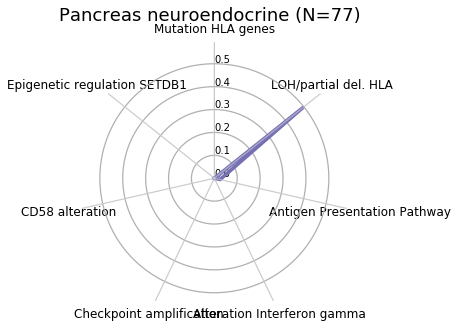

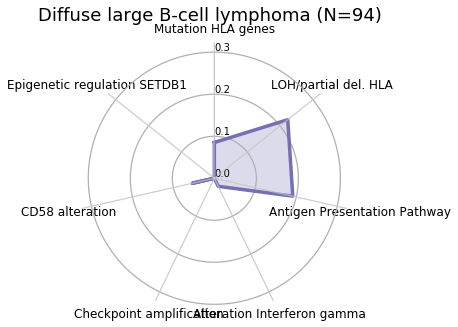

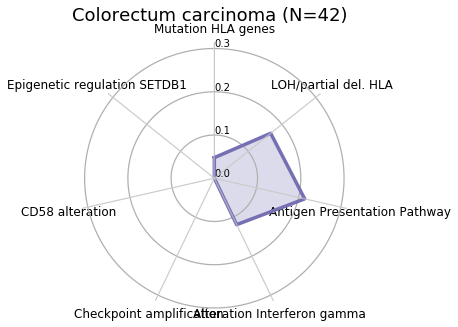

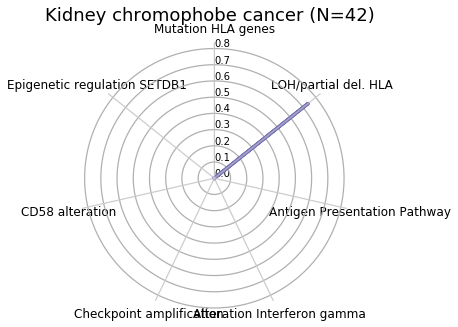

In [27]:
for ttype in ratio_pcawg.loc[["Pancreas neuroendocrine","Diffuse large B-cell lymphoma","Colorectum carcinoma","Kidney chromophobe cancer"]].index:
    plot_radar_ttype(list(ratio_pcawg.loc[ttype][features[:-1]].values),features=features[:-1],label=ttype+f" (N={int(ratio_pcawg.loc[ttype]['n_samples'])})",ttype=ttype)
    

## Analysis of mutual exclusivity

In [28]:
order=list(ttype_general[ttype_general["n_samples"]>=15].sort_values("genetic_immune_escape",ascending=False)["cancer_type"])

##### LOH of HLA-I vs non-targeted (using Fishers' exact test)

In [30]:
l=[]
for ttype in order:
    tmp=df[df["cancer_type"]==ttype]
    total=tmp.shape[0]
    a=tmp[(tmp["loh_lilac"]==True)&(tmp["non_targeted_escape"])].shape[0]
    b=tmp[(tmp["loh_lilac"])&(~tmp["non_targeted_escape"])].shape[0]
    if (a+b) < 15:
        continue
    c=tmp[(~tmp["loh_lilac"])&(tmp["non_targeted_escape"])].shape[0]
    d=tmp[(~tmp["loh_lilac"])&(~tmp["non_targeted_escape"])].shape[0]
    o,p=st.fisher_exact([[a,b],[c,d]],alternative="less")
    l.append([ttype,p,o,a,b,c,d])
df_stats_me=pd.DataFrame(l,columns=["cancer_type","pvalue_fisher","odds_ratio","loh_and_other_gie","loh_not_other_gie","not_loh_and_other_gie","not_loh_not_other_gie"]).sort_values("pvalue_fisher")
df_stats_me

,cancer_type,pvalue_fisher,odds_ratio,loh_and_other_gie,loh_not_other_gie,not_loh_and_other_gie,not_loh_not_other_gie
3,Non small cell lung cancer,0.452613,0.633540,2,23,7,51
5,Esophagus cancer,0.524957,0.000000,0,23,2,59
2,Diffuse large B-cell lymphoma,0.701856,1.136842,6,15,19,54
4,Pancreas carcinoma,0.704660,1.106494,3,55,7,142
6,Breast cancer,0.709215,1.066667,2,16,15,128
1,Pancreas neuroendocrine,0.759740,1.027027,1,37,1,38
0,Kidney chromophobe cancer,1.000000,NaN,0,31,0,11


##### LOH of HLA-I vs non-targeted (using a randomization, part of Supp. Table 4)

In [31]:
rs=[]
for ttype in order:
    tmp=df[df["cancer_type"]==ttype]
    a=tmp[(tmp["loh_lilac"]==True)&(tmp["non_targeted_escape"])].shape[0]
    b=tmp[(tmp["loh_lilac"])&(~tmp["non_targeted_escape"])].shape[0]
    if (a+b) < 15:
        continue
    
    pa=tmp[tmp["loh_lilac"]].shape[0]/tmp.shape[0]
    pb=tmp[(tmp["non_targeted_escape"])].shape[0]/tmp.shape[0]
    counts=tmp[(tmp["loh_lilac"])&((tmp["non_targeted_escape"]))].shape[0] 
    l_data=[]
    N=10000
    for _ in range(N):
        ma=np.random.binomial(1,p=pa,size=tmp.shape[0])
        mb=np.random.binomial(1,p=pb,size=tmp.shape[0])
        overlap=np.nansum(ma&mb)
        l_data.append(overlap)
    pvalue=np.nansum(counts >= np.array(l_data)) / 10000
    rs.append([ttype,pvalue,counts,np.nanmean(l_data)])
simulated_me=pd.DataFrame(rs,columns=["cancer_type","pvalue_simulations","observed_overlap","expected_mean_overlap"]).sort_values("pvalue_simulations")
simulated_me.merge(df_stats_me)[["cancer_type","loh_and_other_gie","loh_not_other_gie","not_loh_and_other_gie","not_loh_not_other_gie","odds_ratio","pvalue_fisher","expected_mean_overlap","pvalue_simulations"]].to_csv("../results/data/mutual_exclusivity_pcawg.tsv",sep="\t",index=False)
simulated_me.merge(df_stats_me)[["cancer_type","loh_and_other_gie","loh_not_other_gie","not_loh_and_other_gie","not_loh_not_other_gie","odds_ratio","pvalue_fisher","expected_mean_overlap","pvalue_simulations"]]
    

    
    

,cancer_type,loh_and_other_gie,loh_not_other_gie,not_loh_and_other_gie,not_loh_not_other_gie,odds_ratio,pvalue_fisher,expected_mean_overlap,pvalue_simulations
0,Non small cell lung cancer,2,23,7,51,0.633540,0.452613,2.6827,0.4928
1,Esophagus cancer,0,23,2,59,0.000000,0.524957,0.5344,0.5823
2,Diffuse large B-cell lymphoma,6,15,19,54,1.136842,0.701856,5.5833,0.6729
3,Pancreas carcinoma,3,55,7,142,1.106494,0.704660,2.7891,0.6965
4,Breast cancer,2,16,15,128,1.066667,0.709215,1.8915,0.7060
5,Pancreas neuroendocrine,1,37,1,38,1.027027,0.759740,0.9932,0.7390
6,Kidney chromophobe cancer,0,31,0,11,NaN,1.000000,0.0000,1.0000
